In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import warnings
from itertools import combinations

import pandas as pd
import numpy as np
import optuna

import boto3
import pymysql
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.dirname(os.getcwd()))
from src.model_utils import (
    get_secret,
    get_db_url,
    FeatureImportanceHandler,
)
from src.plot_utils import StudyVisualizer

In [50]:
warnings.filterwarnings("ignore")

## Hydra

In [51]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base="1.2", config_path="../src/config", job_name="eda")
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

## S3

In [52]:
s3 = boto3.client("s3")

train_channel = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train/',
        distribution="FullyReplicated",
        content_type="text/csv",
        s3_data_type="S3Prefix",
        input_mode="File",
    )
}

train_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f0f67eec250>}

## SageMaker

In [53]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()

## Database Setup

In [54]:
cf = boto3.client("cloudformation")
outputs = cf.describe_stacks(StackName=config["stack_name"])["Stacks"][0]["Outputs"]

# 'Outputs' is a list of dictionaries, and we extract specific outputs based on their OutputKey property
host = [out["OutputValue"] for out in outputs if out["OutputKey"] == "ClusterEndpoint"][
    0
].split(":")[0]
db_name = [out["OutputValue"] for out in outputs if out["OutputKey"] == "DatabaseName"][
    0
]
secret_name = (
    [out["OutputValue"] for out in outputs if out["OutputKey"] == "DBSecretArn"][0]
    .split(":")[-1]
    .split("-")[0]
)

subnets = [
    out["OutputValue"] for out in outputs if out["OutputKey"] == "PrivateSubnets"
][0].split(",")
security_group_ids = [
    out["OutputValue"]
    for out in outputs
    if out["OutputKey"] == "SageMakerSecurityGroup"
][0].split(",")

## Data

In [16]:
df = pd.read_csv(
    f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train/train.csv',
    index_col=0,
)
df.shape

(617, 57)

In [7]:
df.sample(10)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
a20ba8577583,0.837508,3503.18958,85.200147,18.334240,12.113640,5.085066,0.025578,11.242768,1.229900,5174.48380,...,0.173229,1.43782,0.243828,13.590222,109.934713,12581.023680,16.558450,95.637248,21.978000,1
f3f2071d2453,0.517033,4485.62004,85.200147,42.221401,14.316120,9.310809,0.093177,12.074632,1.229900,6286.02064,...,0.173229,1.93546,0.067730,23.050356,72.611063,16158.277710,38.899334,105.603748,21.978000,0
9ba8bfa26e8a,0.217923,5735.54762,85.200147,24.004847,8.138688,6.422775,0.025578,5.879766,4.561172,3853.89660,...,0.173229,1.92038,0.067730,11.181004,251.715996,17084.310370,17.801264,18.384656,21.978000,0
1a14973e1785,0.188012,2351.13406,85.200147,12.291993,8.138688,3.171522,0.025578,7.852292,1.229900,4131.18955,...,0.173229,0.49706,0.101595,10.213596,72.611063,2083.716738,33.440627,25.925760,21.978000,0
508bb5c5cf00,0.260653,1642.84362,85.200147,8.433131,8.138688,3.401856,0.025578,15.049176,1.229900,6678.13788,...,0.173229,0.49706,0.067730,18.752832,72.611063,17089.961580,31.301052,99.430948,21.978000,0
9e725e00b348,0.175193,192.59328,85.200147,48.889242,8.138688,6.183582,0.025578,11.520056,10.605252,5087.15310,...,0.173229,1.11476,0.772122,12.715834,72.611063,28153.526560,19.036636,81.136312,21.978000,0
41216f6cee66,0.653769,7068.54412,85.200147,391.755015,24.520944,3.720780,0.025578,3.396778,1.229900,3436.88252,...,23.518789,1.47581,1.517152,9.888026,72.611063,4518.044568,32.264791,176.662964,0.001317,1
6487b5140ab2,0.209377,2199.46298,85.200147,23.227500,8.138688,4.899027,0.025578,14.526110,1.229900,4392.34270,...,0.173229,0.49706,0.101595,17.869142,72.611063,48734.587490,35.542992,23.670116,21.978000,0
1c612f931833,0.658042,4986.24423,174.615450,44.147735,14.580942,7.592163,0.025578,10.020180,1.229900,7449.30871,...,3.167302,1.67765,0.209963,19.803958,152.269450,4012.195842,39.926330,111.812556,0.226658,0


Data types:

In [40]:
dict(df.dtypes)

{'AB': dtype('float64'),
 'AF': dtype('float64'),
 'AH': dtype('float64'),
 'AM': dtype('float64'),
 'AR': dtype('float64'),
 'AX': dtype('float64'),
 'AY': dtype('float64'),
 'AZ': dtype('float64'),
 'BC': dtype('float64'),
 'BD': dtype('float64'),
 'BN': dtype('float64'),
 'BP': dtype('float64'),
 'BQ': dtype('float64'),
 'BR': dtype('float64'),
 'BZ': dtype('float64'),
 'CB': dtype('float64'),
 'CC': dtype('float64'),
 'CD': dtype('float64'),
 'CF': dtype('float64'),
 'CH': dtype('float64'),
 'CL': dtype('float64'),
 'CR': dtype('float64'),
 'CS': dtype('float64'),
 'CU': dtype('float64'),
 'CW': dtype('float64'),
 'DA': dtype('float64'),
 'DE': dtype('float64'),
 'DF': dtype('float64'),
 'DH': dtype('float64'),
 'DI': dtype('float64'),
 'DL': dtype('float64'),
 'DN': dtype('float64'),
 'DU': dtype('float64'),
 'DV': dtype('float64'),
 'DY': dtype('float64'),
 'EB': dtype('float64'),
 'EE': dtype('float64'),
 'EG': dtype('float64'),
 'EH': dtype('float64'),
 'EJ': dtype('O'),
 'EL':

Convert datatypes:

In [41]:
np.finfo(np.float16)

finfo(resolution=0.001, min=-6.55040e+04, max=6.55040e+04, dtype=float16)

In [142]:
num_cols = [c for c in df.columns if df[c].dtype == "float64"]
cat_cols = [c for c in df.columns if df[c].dtype == "object"]

df[num_cols] = df[num_cols].astype(np.float32)
df[cat_cols + ["Class"]] = df[cat_cols + ["Class"]].astype("category")

In [143]:
dict(df.dtypes)

{'AB': dtype('float32'),
 'AF': dtype('float32'),
 'AH': dtype('float32'),
 'AM': dtype('float32'),
 'AR': dtype('float32'),
 'AX': dtype('float32'),
 'AY': dtype('float32'),
 'AZ': dtype('float32'),
 'BC': dtype('float32'),
 'BD ': dtype('float32'),
 'BN': dtype('float32'),
 'BP': dtype('float32'),
 'BQ': dtype('float32'),
 'BR': dtype('float32'),
 'BZ': dtype('float32'),
 'CB': dtype('float32'),
 'CC': dtype('float32'),
 'CD ': dtype('float32'),
 'CF': dtype('float32'),
 'CH': dtype('float32'),
 'CL': dtype('float32'),
 'CR': dtype('float32'),
 'CS': dtype('float32'),
 'CU': dtype('float32'),
 'CW ': dtype('float32'),
 'DA': dtype('float32'),
 'DE': dtype('float32'),
 'DF': dtype('float32'),
 'DH': dtype('float32'),
 'DI': dtype('float32'),
 'DL': dtype('float32'),
 'DN': dtype('float32'),
 'DU': dtype('float32'),
 'DV': dtype('float32'),
 'DY': dtype('float32'),
 'EB': dtype('float32'),
 'EE': dtype('float32'),
 'EG': dtype('float32'),
 'EH': dtype('float32'),
 'EJ': CategoricalDtyp

### Missing Values

Check missing values:

In [44]:
missing_cols = (
    df.isna()
    .sum(axis=0)
    .sort_values(ascending=False)
    .loc[lambda x: x > 0]
    .index.tolist()
)
missing_cols

['EL', 'BQ', 'CC', 'CB', 'FS', 'FL', 'FC', 'DU', 'GL']

Percentage of missing values:

In [45]:
df.loc[:, missing_cols].isna().sum(axis=0).sort_values(ascending=False) / df.shape[
    0
] * 100

EL    9.724473
BQ    9.724473
CC    0.486224
CB    0.324149
FS    0.324149
FL    0.162075
FC    0.162075
DU    0.162075
GL    0.162075
dtype: float64

<Axes: >

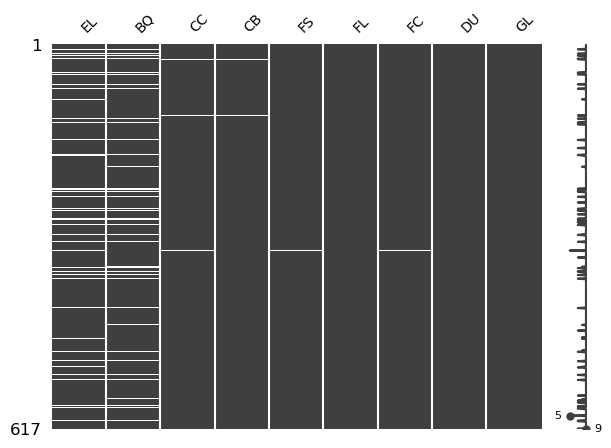

In [46]:
msno.matrix(df.loc[:, missing_cols], figsize=(7, 5), fontsize=10)

<Axes: >

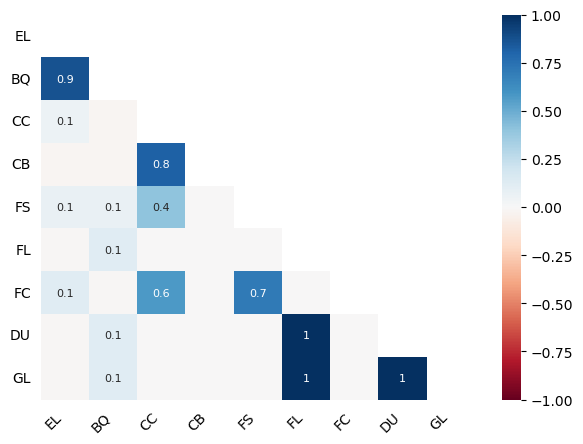

In [47]:
msno.heatmap(df.loc[:, missing_cols], figsize=(7, 5), fontsize=10)

Entries marked <1 or >-1 have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so. 

<Axes: >

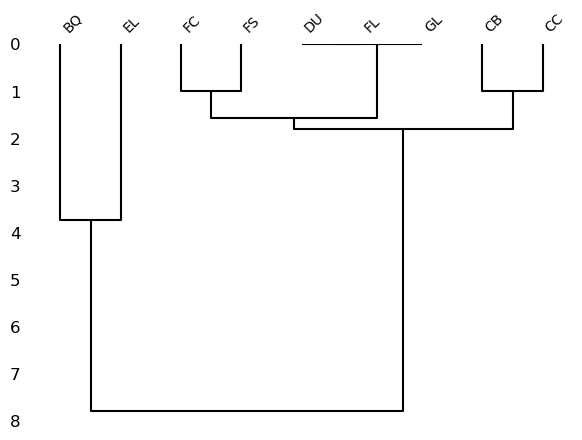

In [48]:
msno.dendrogram(df.loc[:, missing_cols], figsize=(7, 5), fontsize=10)

To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at **a distance of zero** fully predict one another's presence--- one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on.

Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If our own interpretation of the dataset is that these columns actually are or ought to be match each other in nullity, then the height of the cluster leaf tells us, in absolute terms, how often the records are "mismatched" or incorrectly filled--- that is, how many values we would have to fill in or drop, if we are so inclined.

* FC and FS, CB and CC are very closely matched in term of nullity.

* BQ and EL have many more missing values and are also pretty closely matched in terms of missingness.

### Numerical Feature Ranges

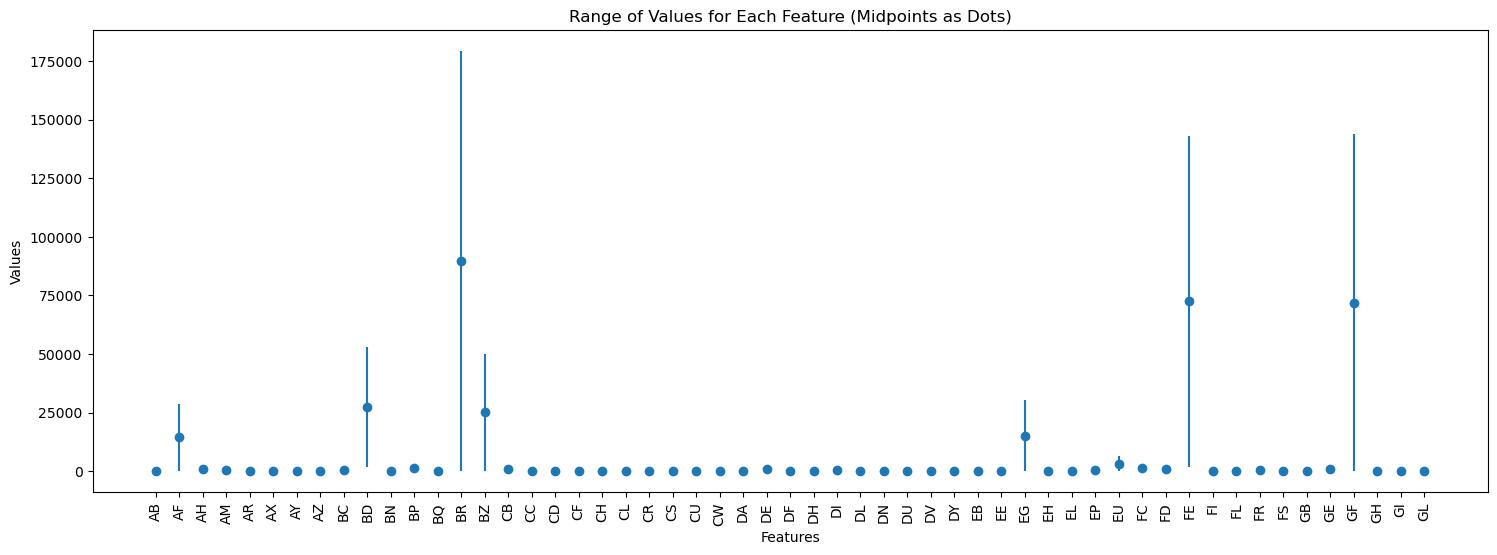

In [49]:
feature_max_values = df.dropna().loc[:, num_cols].max(axis=0).values
feature_min_values = df.dropna().loc[:, num_cols].min(axis=0).values
feature_range = feature_max_values - feature_min_values
feature_labels = df.loc[:, num_cols].columns.tolist()

fig, ax = plt.subplots(figsize=(18, 6))
ax.errorbar(
    x=feature_labels,
    y=(feature_max_values + feature_min_values) / 2,
    yerr=np.abs(feature_range) / 2,
    fmt="o",
)
ax.set_xlabel("Features")
ax.set_ylabel("Values")
ax.set_title("Range of Values for Each Feature (Midpoints as Dots)")
plt.xticks(rotation="vertical")
plt.show();

Remove features with large ranges for clearer view:

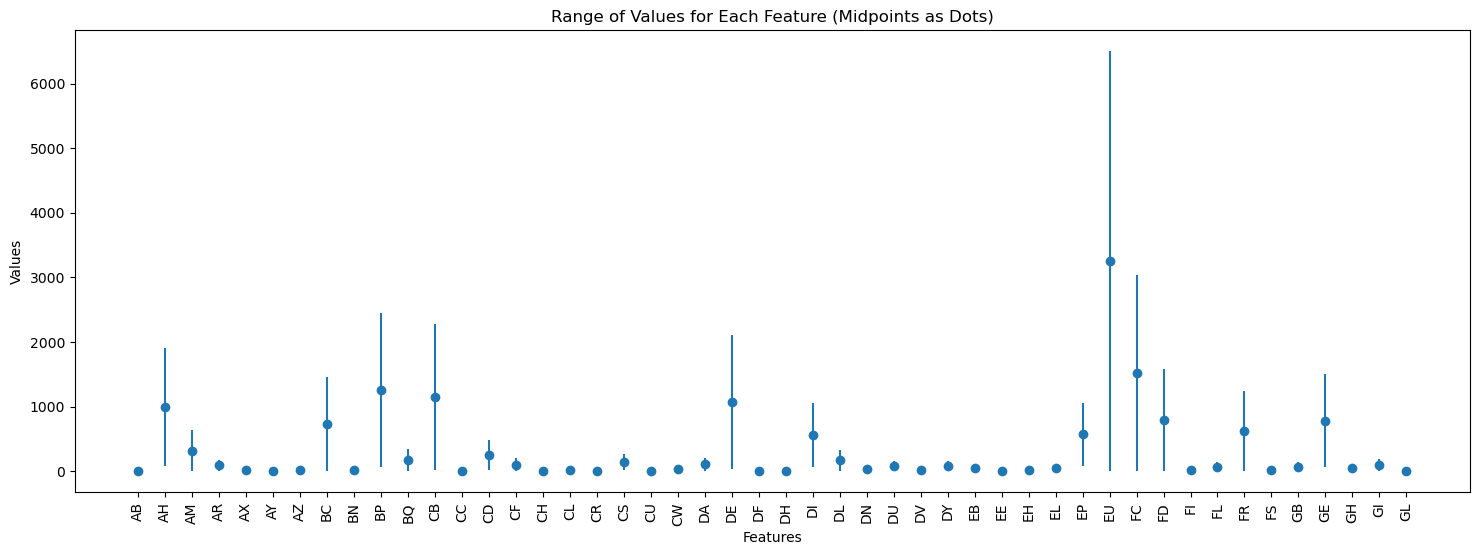

In [63]:
large_range_num_cols = ["AF", "BD", "BR", "BZ", "EG", "FE", "GF"]

feature_max_values = (
    df.dropna()
    .loc[:, num_cols]
    .drop(columns=large_range_num_cols, axis=1)
    .max(axis=0)
    .values
)
feature_min_values = (
    df.dropna()
    .loc[:, num_cols]
    .drop(columns=large_range_num_cols, axis=1)
    .min(axis=0)
    .values
)
feature_range = feature_max_values - feature_min_values
feature_labels = (
    df.loc[:, num_cols].drop(columns=large_range_num_cols, axis=1).columns.tolist()
)

fig, ax = plt.subplots(figsize=(18, 6))
ax.errorbar(
    x=feature_labels,
    y=(feature_max_values + feature_min_values) / 2,
    yerr=np.abs(feature_range) / 2,
    fmt="o",
)
ax.set_xlabel("Features")
ax.set_ylabel("Values")
ax.set_title("Range of Values for Each Feature (Midpoints as Dots)")
plt.xticks(rotation="vertical")
plt.show();

### Distribution of Numerical Features

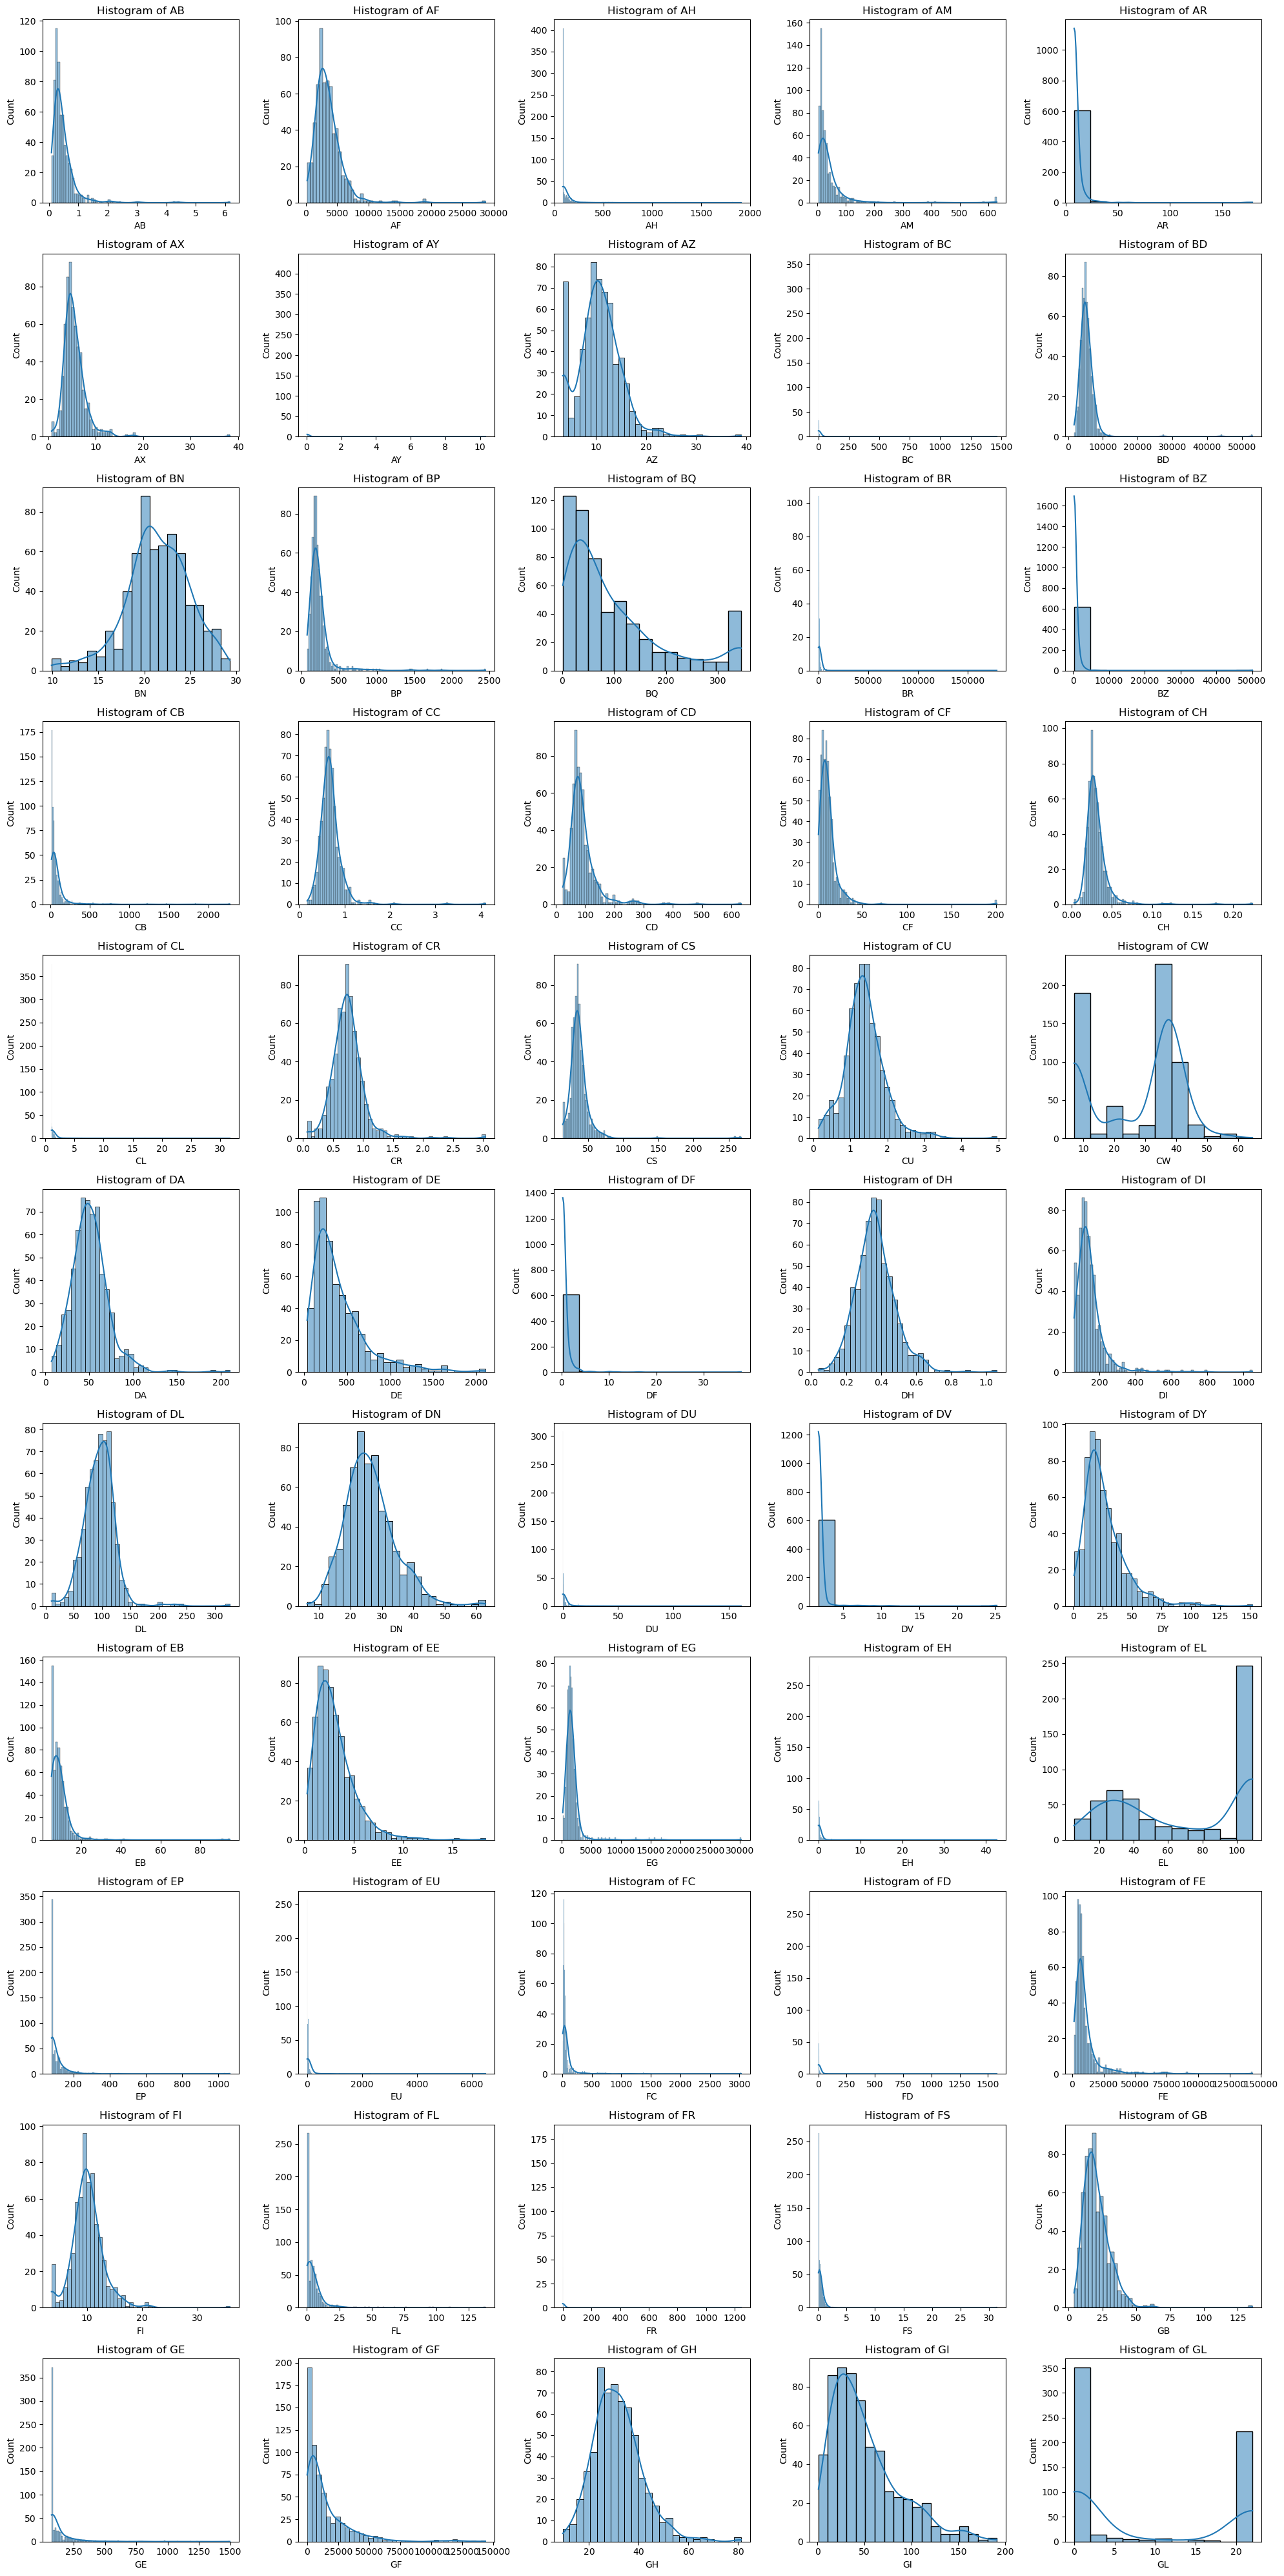

In [82]:
fig, axs = plt.subplots(11, 5, figsize=(20, 40))
axs = axs.ravel()
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axs[i])
    axs[i].set_title(f"Histogram of {col}")
plt.tight_layout()
plt.show();

### Categorical Feature

In [116]:
np.unique(df.loc[:, cat_cols], return_counts=True)

(array(['A', 'B'], dtype=object), array([222, 395]))

Correlation with target via chi-squared test of independence, which is fitting since this is a small sample and statistical tests can be useful. We control $\alpha$ type-I (false positive) error rate at $1\%$ since we consider the cost of false concluding that the categorical feature are the target are dependent greater.

In [171]:
test_result = chi2_contingency(
    pd.crosstab(df["Class"], df[cat_cols[0]]), correction=True
)

if test_result.pvalue < 0.01:
    print(
        "Reject null hypothesis that the target and the categorical feature are independent"
    )
else:
    print(
        "Fail to reject the null hypothesis that the target and the categorical feature are independent"
    )

Fail to reject the null hypothesis that the target and the categorical feature are independent


### Target Class Distribution

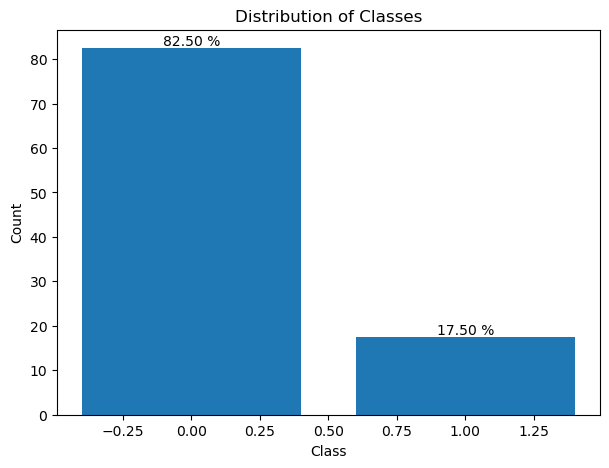

In [74]:
X = df.drop(columns=["Class"], axis=1)
y = df["Class"]

class_dist = (y.value_counts() / len(y) * 100).to_dict()

fig, ax = plt.subplots(figsize=(7, 5))
bar_plot = ax.bar(class_dist.keys(), class_dist.values())
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("Distribution of Classes")
for rect in bar_plot:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{height:.2f} %",
        ha="center",
        va="bottom",
    )
plt.show();

## PCA

In [108]:
pca_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=X.loc[:, num_cols].shape[1], whiten=True)),
    ]
)

pca_pipeline.fit(X.loc[:, num_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('pca', PCA(n_components=55, whiten=True))])

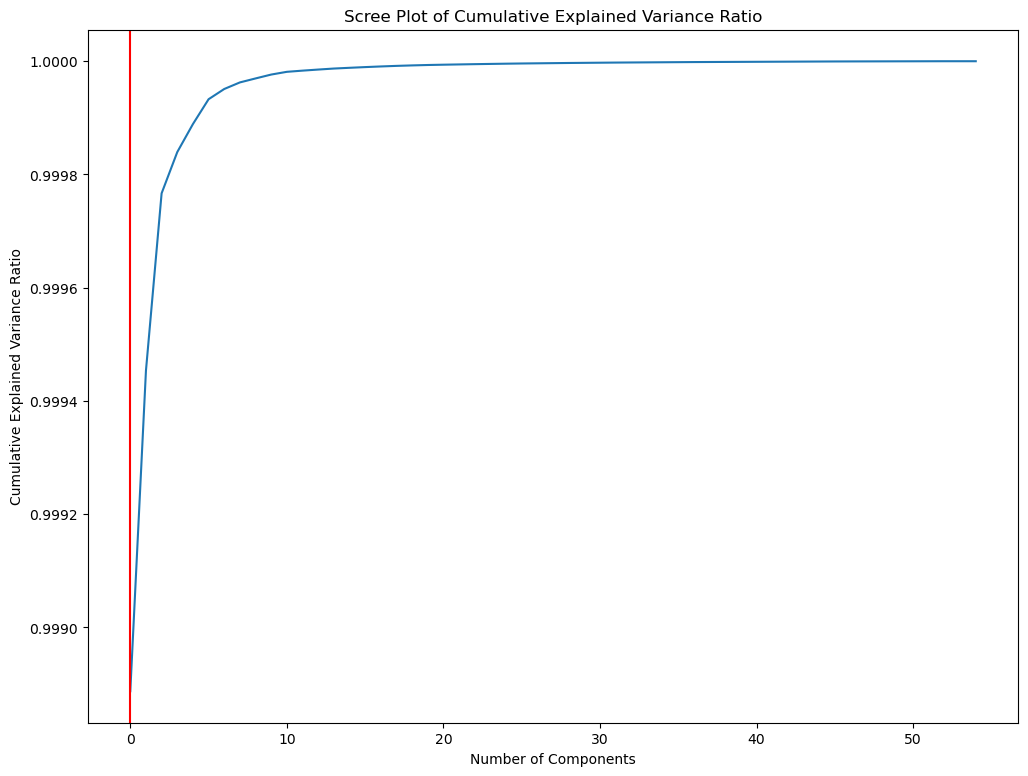

In [109]:
# Scree plot of cumulative explained variance ratio
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(np.cumsum(pca_pipeline.named_steps["pca"].explained_variance_ratio_))
# Add vertical line at 95% variance
ax.axvline(
    x=np.where(
        np.cumsum(pca_pipeline.named_steps["pca"].explained_variance_ratio_) > 0.95
    )[0][0],
    color="r",
)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cumulative Explained Variance Ratio")
ax.set_title("Scree Plot of Cumulative Explained Variance Ratio")
plt.show();

The data is extremely low-dimensional.

In [110]:
first_two_pc = np.cumsum(pca_pipeline["pca"].explained_variance_ratio_)[1] * 100

print(
    f"The first two principal components explain {first_two_pc:.2f} % of the variance"
)

The first two principal components explain 99.95 % of the variance


The eigen vectors of the first two component:

In [111]:
# Get the eigenvectors of the first two principal components do we need to transpose?
eigenvectors = pca_pipeline["pca"].components_[:2].T
eigenvectors_df = pd.DataFrame(
    eigenvectors, columns=["PC1", "PC2"], index=num_cols
).style.background_gradient(cmap="coolwarm")
eigenvectors_df

,PC1,PC2
AB,0.000276,0.000382
AF,0.000035,0.000423
AH,0.000950,-0.001503
AM,0.000416,-0.000757
AR,0.000696,-0.002461
AX,0.000063,-0.000359
AY,0.002121,-0.007654
AZ,0.000016,-0.000205
BC,0.007399,0.007289
BD,0.000526,-0.000729


## Baseline Model

Random forest classifier baseline with minimal preprocessing:

In [37]:
test_study_name = "test_study"

test_estimator = SKLearn(
    # Sagemaker
    entry_point=config["baseline"]["entry_point"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    source_dir=config["src_dir_path"],
    role=role,
    instance_type="local",
    instance_count=config["baseline"]["instance_count"],
    output_path=config["output_path"],
    code_location=config["code_location"],
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": test_study_name,
        "db_secret": secret_name,
        "region_name": sagemaker_session._region_name,
        "n_trials": 2,
        "test_mode": 1,
    },
)
test_estimator

Test locally:

In [38]:
!sudo rm -rf /tmp/tmp*

In [39]:
test_estimator.fit(train_channel)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-06-25-01-36-04-168
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-7ls5m:
    command: train
    container_name: xac7260yaq-algo-1-7ls5m
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
    networks:
      sagemaker-local:
        aliases:
        - algo-1-7ls5m
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmp_fa8iibb/algo-1-7ls5m/input:/opt/ml/input
    - /tmp/tmp_fa8ii

Creating xac7260yaq-algo-1-7ls5m ... 
Creating xac7260yaq-algo-1-7ls5m ... done
Attaching to xac7260yaq-algo-1-7ls5m
xac7260yaq-algo-1-7ls5m | 2023-06-25 01:36:06,264 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
xac7260yaq-algo-1-7ls5m | 2023-06-25 01:36:06,268 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
xac7260yaq-algo-1-7ls5m | 2023-06-25 01:36:06,277 sagemaker_sklearn_container.training INFO     Invoking user training script.
xac7260yaq-algo-1-7ls5m | 2023-06-25 01:36:06,500 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
xac7260yaq-algo-1-7ls5m | /miniconda3/bin/python -m pip install -r requirements.txt
xac7260yaq-algo-1-7ls5m | Collecting optuna==3.1.0 (from -r requirements.txt (line 1))
xac7260yaq-algo-1-7ls5m |   Downloading optuna-3.1.0-py3-none-any.whl (365 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 4.8 MB/s eta 0:00:0000:01eta -:--:--
xac7260

INFO:root:creating /tmp/tmp_fa8iibb/artifacts/output/data
INFO:root:copying /tmp/tmp_fa8iibb/algo-1-7ls5m/output/success -> /tmp/tmp_fa8iibb/artifacts/output


xac7260yaq-algo-1-7ls5m exited with code 0
Aborting on container exit...
===== Job Complete =====


Delete test study:

In [15]:
db_url = get_db_url(
    host=host,
    db_name=db_name,
    db_secret=secret_name,
    region_name=sagemaker_session._region_name,
)

optuna.study.delete_study(study_name=test_study_name, storage=db_url)

Re-instantiate estimator:

In [9]:
baseline_estimator = SKLearn(
    # Entry points and framework
    entry_point=config["baseline"]["entry_point"],
    base_job_name=config["baseline"]["base_job_name"],
    source_dir=config["src_dir_path"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    # Sagemaker
    role=role,
    instance_type=config["baseline"]["instance_type"],
    instance_count=config["baseline"]["instance_count"],
    volume_size=config["volume_size"],
    output_path=config["output_path"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    sagemaker_session=sagemaker_session,
    # Spot training
    use_spot_instances=config["use_spot_instances"],
    max_retry_attempts=config["max_retry_attempts"],
    max_run=config["max_run"],
    max_wait=config["max_run"],  # This should be equal to or greater than max_run
    checkpoint_s3_uri=os.path.join(config["checkpoint_s3_uri"], "baseline"),
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "db_secret": secret_name,
        "study_name": config["baseline"]["study_name"],
        "region_name": sagemaker_session._region_name,
        "n_trials": 100,
        "test_mode": 0,
    },
)
baseline_estimator

### Hyperparameter Tuning

In [10]:
baseline_estimator.fit(train_channel)

Using provided s3_resource


INFO:sagemaker:Creating training-job with name: baseline-training-2023-06-25-06-32-51-475


2023-06-25 06:32:51 Starting - Starting the training job...
2023-06-25 06:33:07 Starting - Preparing the instances for training......
2023-06-25 06:34:03 Downloading - Downloading input data...
2023-06-25 06:34:43 Training - Training image download completed. Training in progress...2023-06-25 06:35:00,216 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-06-25 06:35:00,219 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-25 06:35:00,227 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-06-25 06:35:00,474 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 28.0 MB/s eta

### Hyperparameter Tuning Results

In [9]:
study = optuna.study.load_study(
    study_name=config["baseline"]["study_name"], storage=db_url
)
study

List all tables in the database:

In [10]:
secret = get_secret(secret_name=secret_name, region_name=sagemaker_session._region_name)

with pymysql.connect(
    host=host, user=secret["username"], password=secret["password"], db=db_name
) as connection:
    with connection.cursor() as cursor:
        cursor.execute("SHOW TABLES;")

        rows = cursor.fetchall()

        for row in rows:
            print(row)

('alembic_version',)
('studies',)
('study_directions',)
('study_system_attributes',)
('study_user_attributes',)
('trial_heartbeats',)
('trial_intermediate_values',)
('trial_params',)
('trial_system_attributes',)
('trial_user_attributes',)
('trial_values',)
('trials',)
('version_info',)


In [11]:
hpo_visualizer = StudyVisualizer(study=study)
hpo_visualizer

History plot:

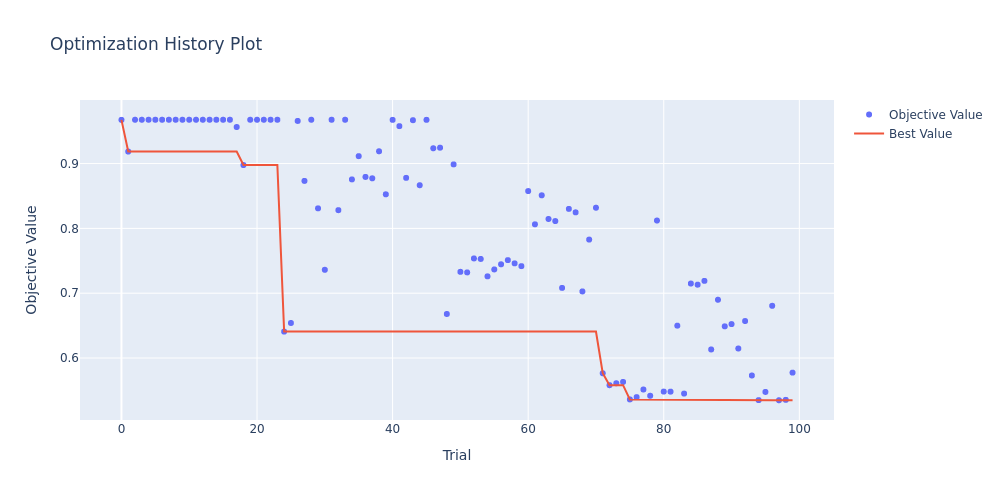

In [12]:
hpo_visualizer.plot_optimization_history(figsize=(1000, 500))

Parallel coordinate plot:

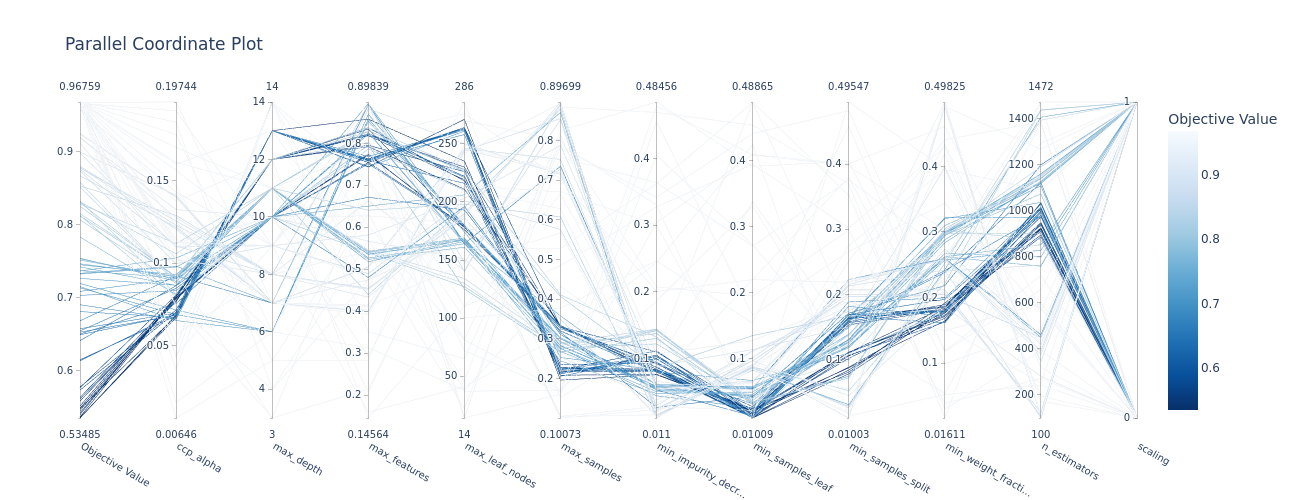

In [13]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500),
    params=[
        "n_estimators",
        "max_depth",
        "min_samples_split",
        "min_samples_leaf",
        "min_weight_fraction_leaf",
        "max_features",
        "scaling",
        "max_leaf_nodes",
        "min_impurity_decrease",
        "max_samples",
        "ccp_alpha",
    ],
)

Importance plot:

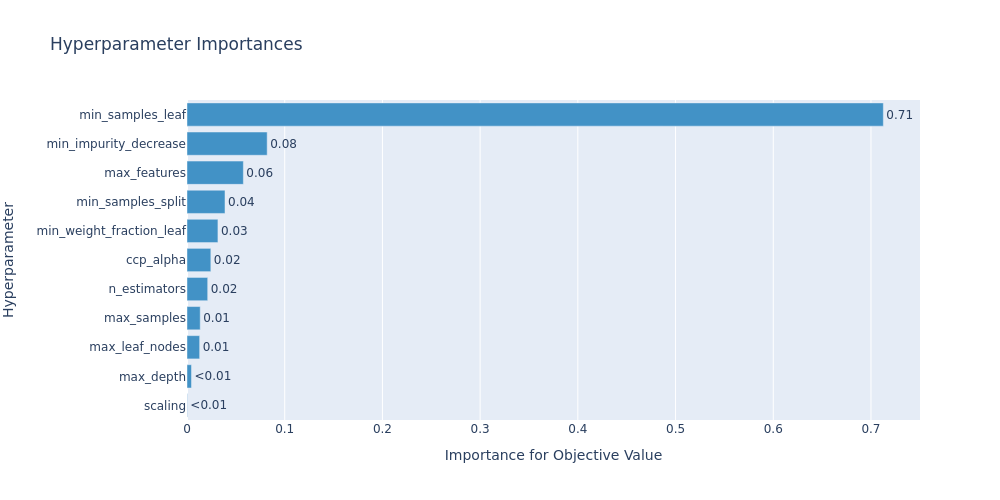

In [14]:
hpo_visualizer.plot_param_importances(figsize=(1000, 500))

Pairwise contour plot of top 3 most importance hyperparameters:

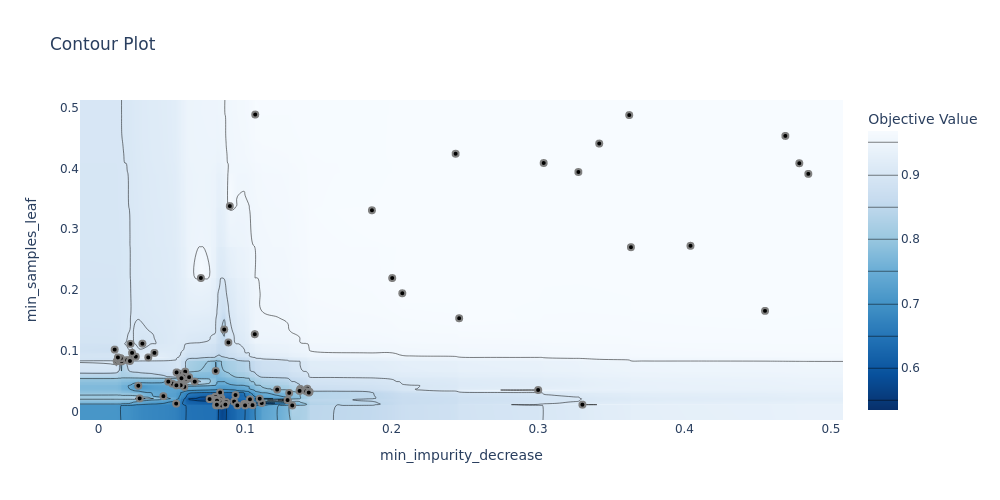

In [15]:
combs = list(
    combinations(["min_samples_leaf", "min_impurity_decrease", "max_features"], 2)
)

hpo_visualizer.plot_contour(figsize=(1000, 500), params=combs[0])

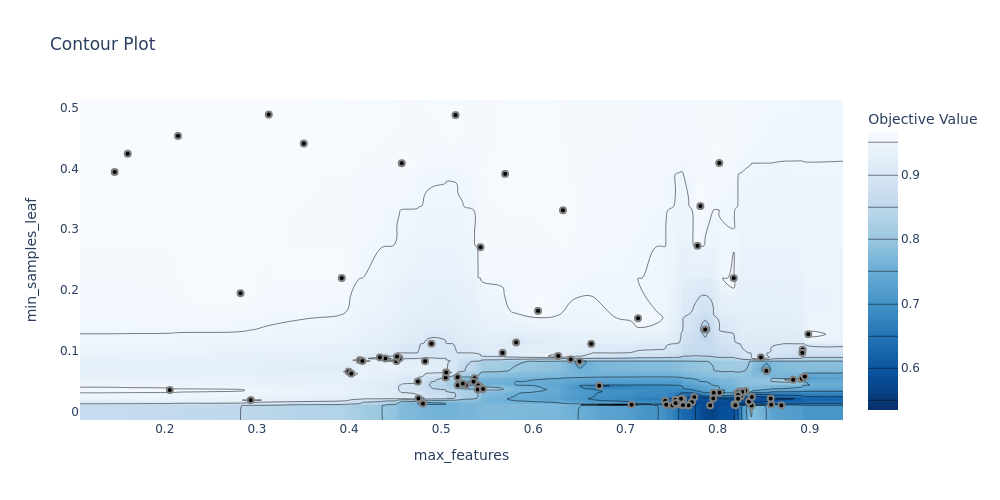

In [16]:
hpo_visualizer.plot_contour(figsize=(1000, 500), params=combs[1])

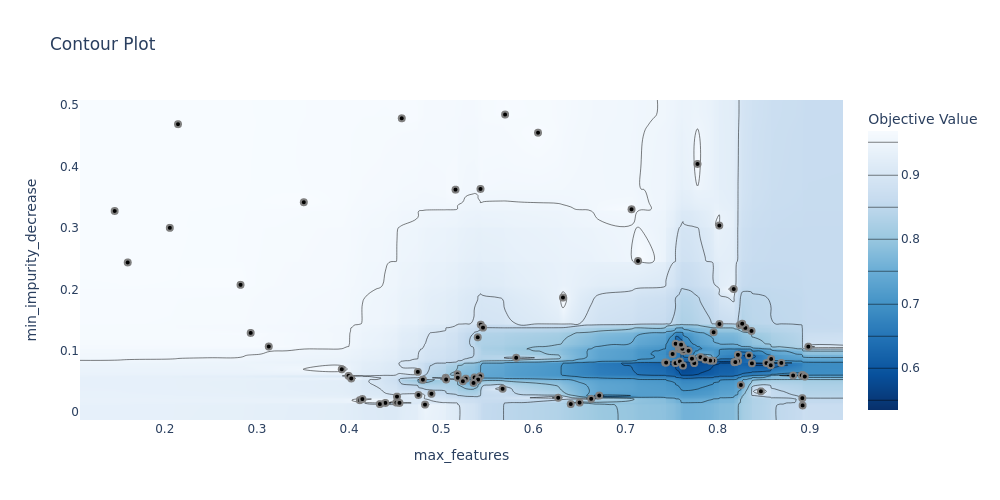

In [17]:
hpo_visualizer.plot_contour(figsize=(1000, 500), params=combs[2])

Slice plots for single hyperparameters:

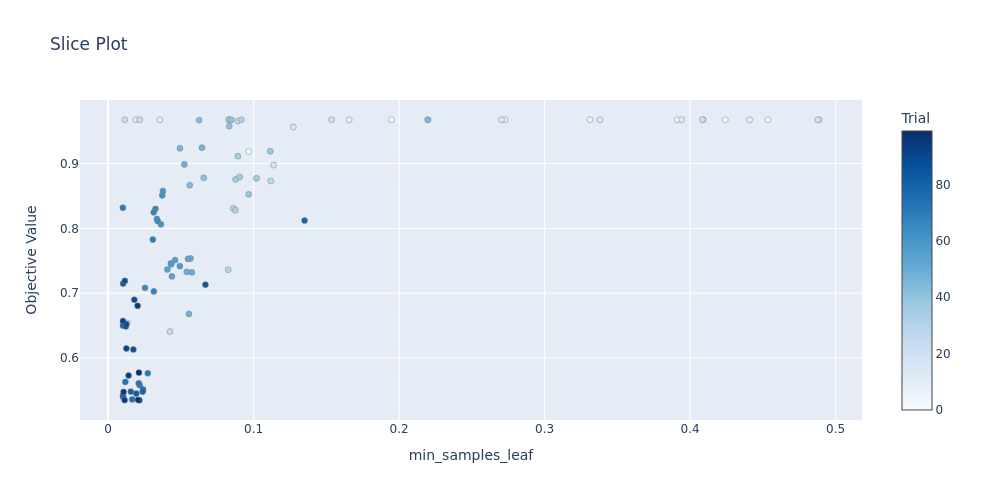

In [18]:
hpo_visualizer.plot_slice(figsize=(1000, 500), params=["min_samples_leaf"])

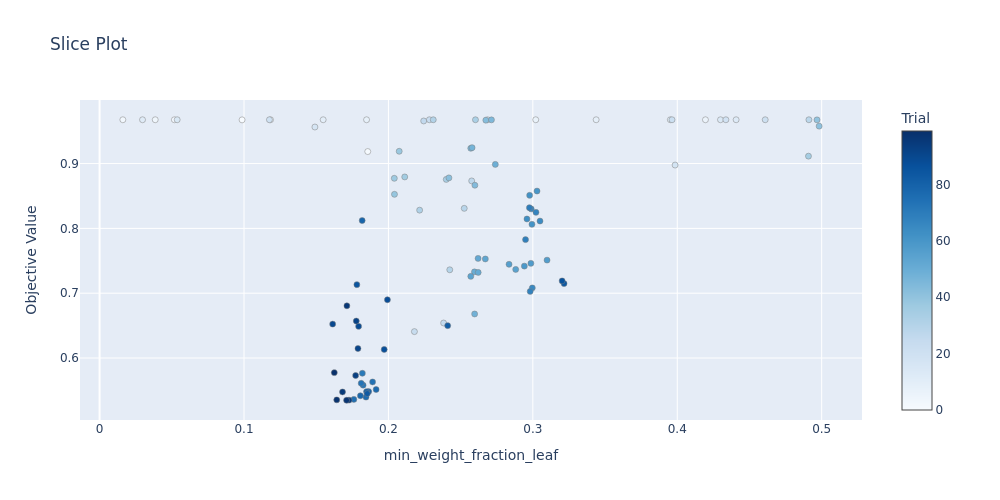

In [19]:
hpo_visualizer.plot_slice(figsize=(1000, 500), params=["min_weight_fraction_leaf"])

### Feature Importance

In [27]:
imp_handler = FeatureImportanceHandler(
    s3_bucket=config["s3_bucket"],
    s3_key=config["s3_key"],
    job_name="baseline-training-2023-06-25-06-32-51-475",
    trial_number=study.best_trial.number,
)

feature_importances = imp_handler.download()

Take the average of importance across the 20 folds:

In [38]:
avg_feat_importances = np.zeros(shape=(len(feature_importances["fold_1"]),))

for feat_imp in feature_importances.values():
    # Utilize the fact that the keys (feature names) are already sorted by optuna, so we can grab the dictionary values directly
    avg_feat_importances += np.fromiter(feat_imp.values(), dtype=float)

avg_feat_importances /= len(feature_importances)

avg_feat_importances_df = pd.DataFrame(
    avg_feat_importances,
    index=feature_importances["fold_1"].keys(),
    columns=["importance"],
).sort_values(by="importance", ascending=False)

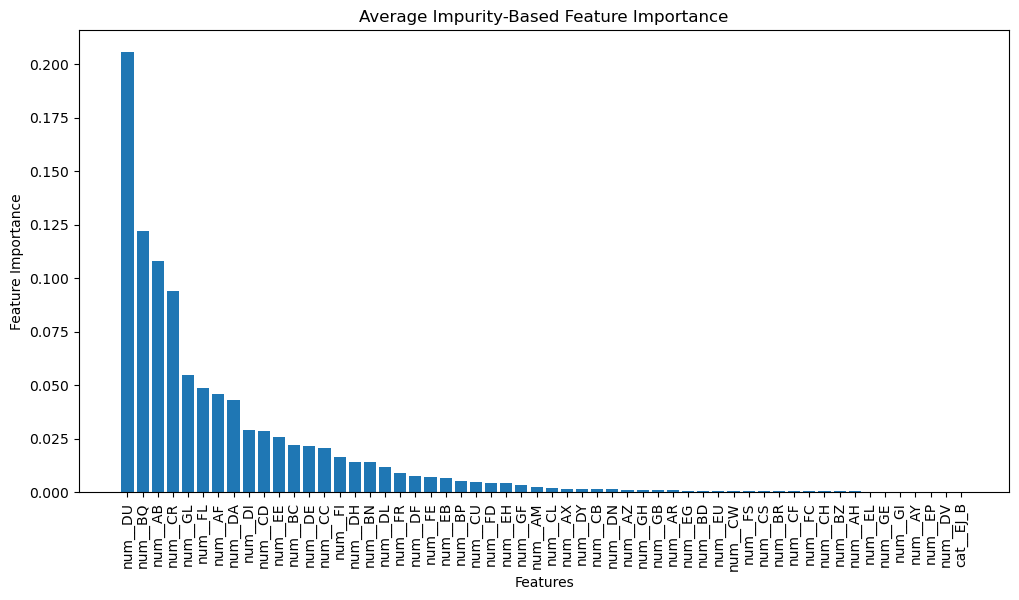

In [39]:
plt.figure(figsize=(12, 6))
plt.bar(avg_feat_importances_df.index, avg_feat_importances_df["importance"])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Average Impurity-Based Feature Importance")
plt.show();

List of features to generate polynomial features and pairwise interactions (top 5):

In [47]:
top_5_feat = [
    col.replace("num__", "") for col in avg_feat_importances_df.index[:5].tolist()
]
top_5_feat

['DU', 'BQ', 'AB', 'CR', 'GL']

List of features to generate features using mathematical operations:

In [48]:
top_15_feat = [
    col.replace("num__", "") for col in avg_feat_importances_df.index[:15].tolist()
]
top_15_feat

['DU',
 'BQ',
 'AB',
 'CR',
 'GL',
 'FL',
 'AF',
 'DA',
 'DI',
 'CD',
 'EE',
 'BC',
 'DE',
 'CC',
 'FI']

Delete study to free-up space:

In [55]:
optuna.study.delete_study(study_name=config["baseline"]["study_name"], storage=db_url)